In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import argparse
import os

In [2]:
DIR_TRAIN = "dataset-cropped/Train/"
DIR_TEST = "dataset-cropped/Test/"

In [3]:
label_data = pd.read_csv("dataset-cropped/label.csv")
label_data

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_001,159,9,2
1,TPS_002,112,87,2
2,TPS_003,173,27,3
3,TPS_004,207,20,3
4,TPS_005,213,30,4
...,...,...,...,...
495,TPS_496,11,150,60
496,TPS_497,20,105,18
497,TPS_498,11,168,24
498,TPS_499,39,130,32


In [4]:
images = []
labels = []

df = pd.read_csv("dataset-cropped/label.csv")

for tps in os.listdir(DIR_TRAIN):
    for paslon in os.listdir(os.path.join(DIR_TRAIN, tps)):
        for section in os.listdir(os.path.join(DIR_TRAIN, tps, paslon)):
            path = os.path.join(DIR_TRAIN, tps, paslon, section)

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (40, 240))
            img = cv2.GaussianBlur(img, (5, 5), 0)
            # imt = cv2.medianBlur(img, 5)

            th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 2)
            # cv2.floodFill(th, None, (0, 0), 123, )
            
            th = th / 255.0
            images.append(th)
    
    curr_tps = df[df['tps'] == tps]
    for col in (['suara_paslon_1', 'suara_paslon_2', 'suara_paslon_3']):
        label_str = '{:03d}'.format(curr_tps[col].values[0])
        labels.extend([int(n) for n in label_str])

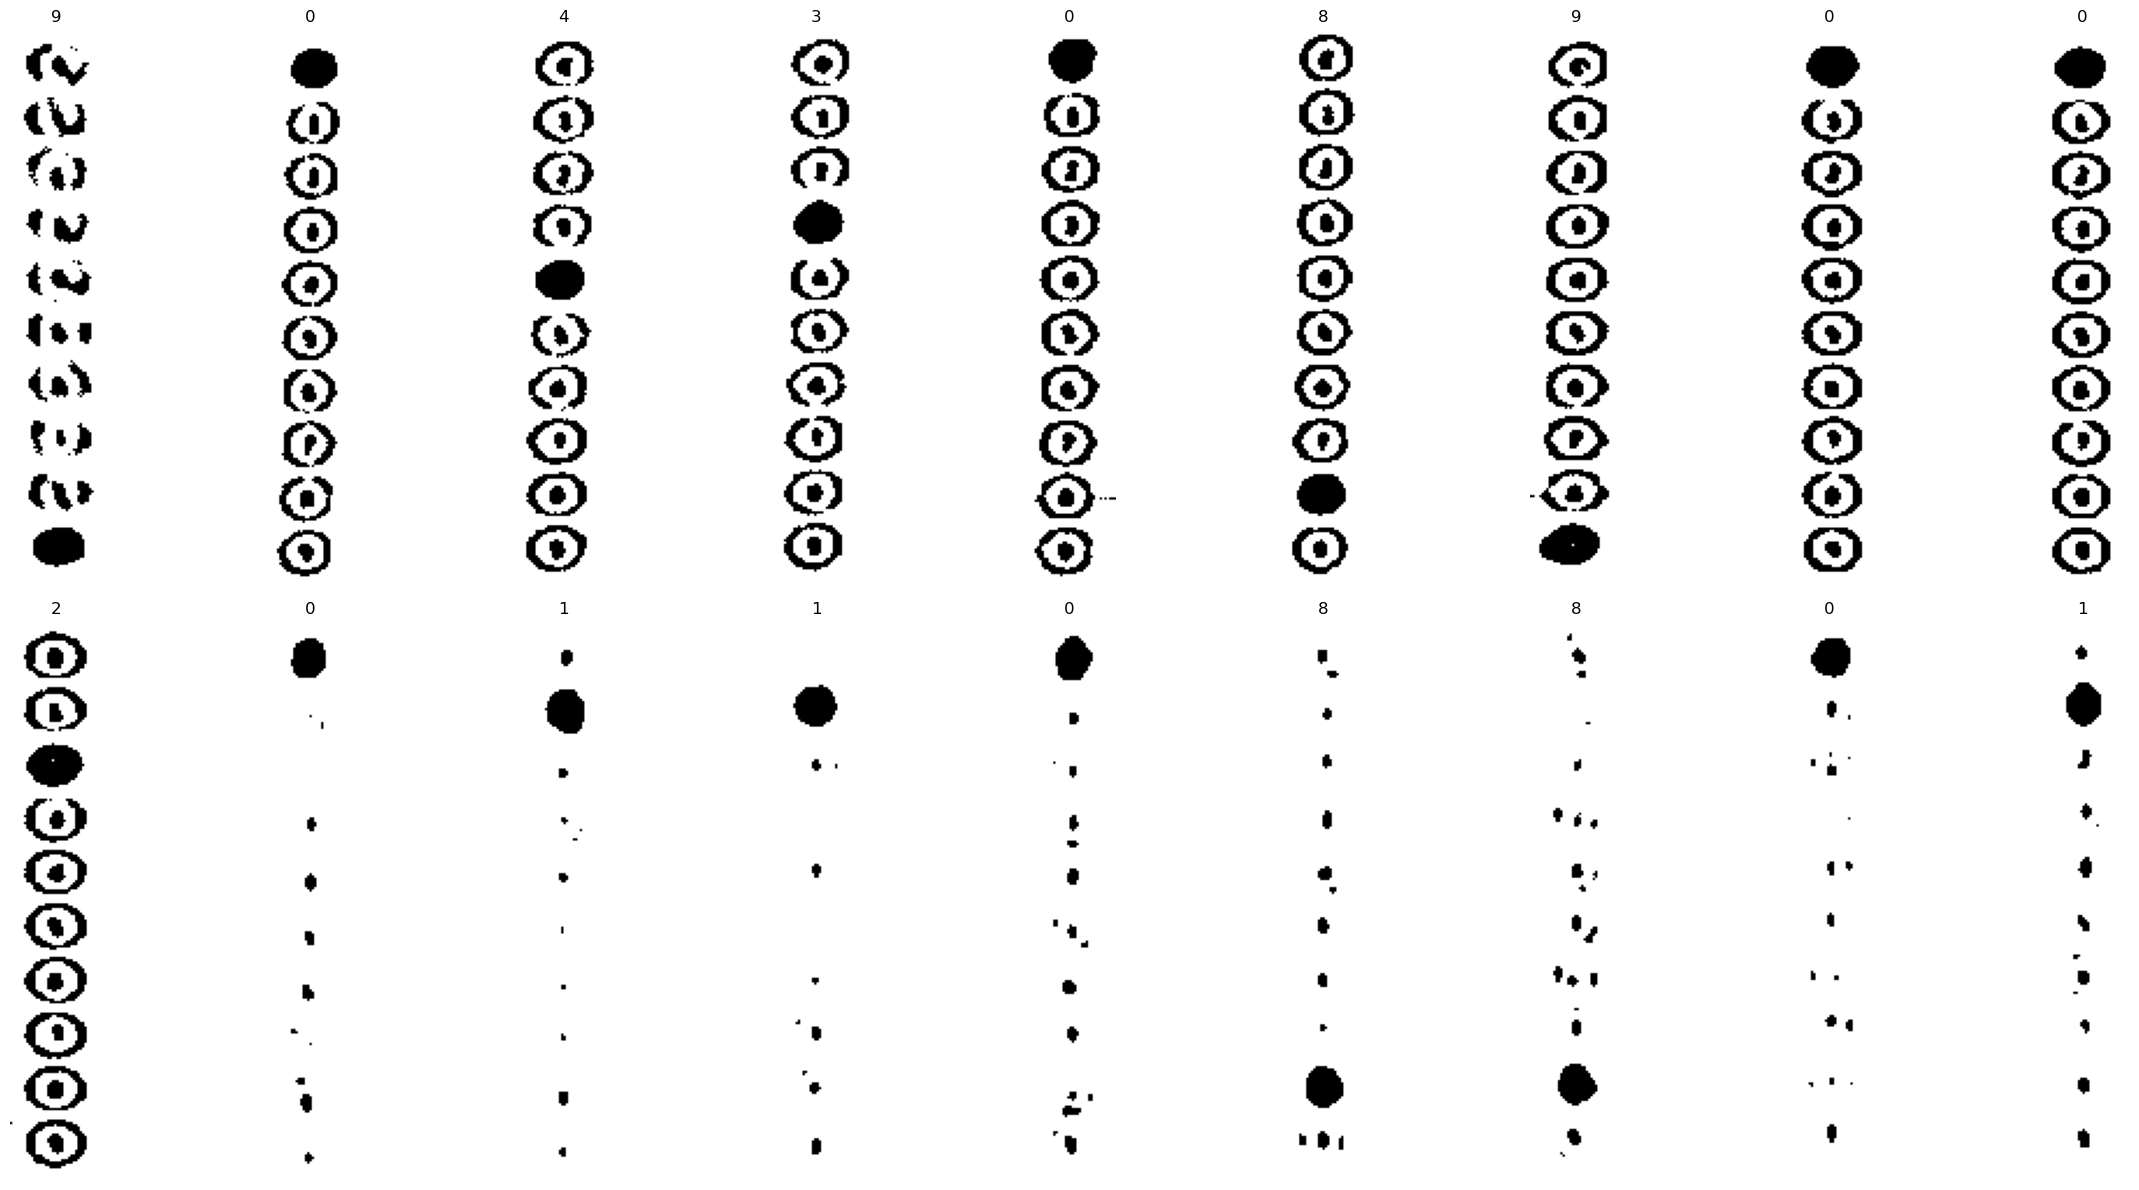

In [5]:
plt.figure(figsize=(24, 12))
for i in range (18):
    plt.subplot(2, 9, i + 1)
    plt.axis("off")
    fig = plt.imshow(images[i+1520], 'gray')
    plt.title(labels[i+1520])

plt.tight_layout()
plt.show()

In [6]:
images = np.array(images)
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_val = np.repeat(x_val[..., np.newaxis], 3, -1)

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights='imagenet', include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False

x_train  = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [9]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 40, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 40, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 40, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 20, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 20, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 5, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 5, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 5, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 2, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 2, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 2, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 2, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    base_model,
    Flatten(),
    Dense(200, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='softmax')
])

In [11]:
# HYPERPARAMETERS
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

In [12]:
print(x_train.shape)

(3326, 240, 40, 3)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, 
          y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)], 
          validation_data=(x_val, y_val))

Epoch 1/30
103/104 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.3076 - loss: 2.1223

KeyboardInterrupt: 